In [2]:
from db.helpers import new_sales_collection
from db.queries import new_sales_refenrece_ids_with_sales_count
from db.helpers import gm_sales_collection
import pandas as pd
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import random

/home/rageq8/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
def prophet_forecast_model(df: pd.DataFrame,key):
    tmp = df[[key, "Sales_Period"]].copy()
    tmp = tmp.set_index("Sales_Period")
    tmp = tmp.reset_index()[["Sales_Period", key]].rename(
        columns={"Sales_Period": "ds", key: "y"}
    )
    model = Prophet(
        yearly_seasonality=False,
        seasonality_mode = 'multiplicative',
        # changepoint_prior_scale=30,
        # seasonality_prior_scale=30,
        )
    return model.fit(tmp)


def get_prediction(model: Prophet, number_of_months):
    future_dates = model.make_future_dataframe(periods=number_of_months, freq="MS")
    predictions = model.predict(future_dates)
    return predictions

def find_seg(data: list[dict], seg_len: int=3):
    seg = []
    for i in data:
        if i["Monthly_Sales"] == None and len(seg) > 0:
            seg.append(i)
        if i["Monthly_Sales"] != None and len(seg) == 0:
            seg.append(i)

        if i["Monthly_Sales"] != None and len(seg) > 0:
            if len(seg) == 1:
                seg.append(i)
            else:
                if len(seg) > seg_len:
                    seg = []
                    seg.append(i)
                    continue
                seg.append(i)
                yield seg
                seg = []

{'_id': 'Foodservice 786', 'fieldN': 31}


<Axes: xlabel='Sales_Period'>

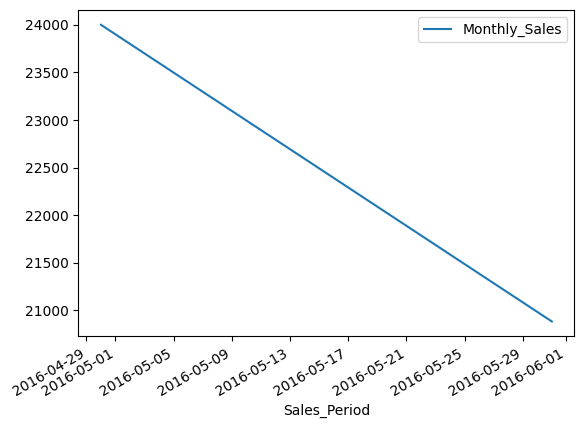

In [49]:
import numpy as np
reference_ids = list(new_sales_refenrece_ids_with_sales_count()) 
# id = random.choice(reference_ids) 
id = {'_id': 'Foodservice 786', 'fieldN': 31}

 
print(id)
sales = list(
    new_sales_collection.find(
        {
            "Reference_Full_ID": id['_id'],
            # "Reference_Full_ID":"Foodservice 4905"
            # "$and": [{"Sales_Month": {"$ne":4}},{"Sales_Year":{"$ne":2021}}],
        }
    ).sort("Sales_Period")
)
"""
issues to look for
- if all sales have the same value,


"""

sales = list(find_seg(sales))[0]

df = pd.DataFrame(sales)
df.plot(x="Sales_Period", y="Monthly_Sales")
# df = df.replace(0, np.nan)
# m = prophet_forecast_model(df,"Weekday_Store_Sales")
# forcast = get_prediction(m,1)
# display(forcast[['ds','yhat']])
# display(forcast)
# display(forcast[['ds','yhat']])
# plot_plotly(m,forcast)
# view generated sales charts

,_id,Primary_ID,Primary_Sheet,Primary_Full_ID,Reference_ID,Reference_Sheet,Reference_Full_ID,Company_Name,Industry_Level_2,Product_Focus,...,Store_Opening_Year,Store_Closing_Day,Store_Closing_Month,Store_Closing_Year,Info_Date,Source,Study,Researcher,Sales_Month,Sales_Year
0,64de1fc166c496bec71a41c4,8310,Sales,Sales 8310,786,Foodservice,Foodservice 786,Kuwait Food Company (Americana),Fast Food,Burger,...,0.0,0.0,0.0,0.0,2016-04-28,Survey,,Ali Boshehry,4,2016
1,64de1fc166c496bec71a41c4,8310,Sales,Sales 8310,786,Foodservice,Foodservice 786,Kuwait Food Company (Americana),Fast Food,Burger,...,0.0,0.0,0.0,0.0,2016-04-28,Survey,,Ali Boshehry,4,2016
2,64de1fc166c496bec71a41c5,8311,Sales,Sales 8311,786,Foodservice,Foodservice 786,Kuwait Food Company (Americana),Fast Food,Burger,...,0.0,0.0,0.0,0.0,2018-11-01,Algorithm,,Algorithm,5,2016


<Axes: xlabel='Sales_Period'>

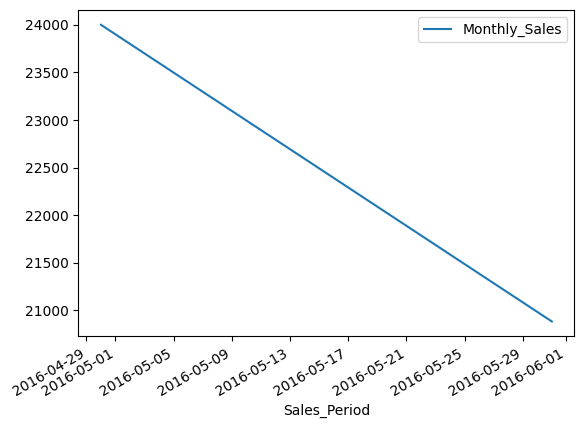

In [50]:
tmp_df = df.copy()
display(tmp_df)
tmp_df['Monthly_Sales'] = tmp_df['Monthly_Sales'].interpolate()
tmp_df.plot(x='Sales_Period',y='Monthly_Sales')

In [70]:
for i in new_sales_collection.find({"Monthly_Sales":None,"Level_1_Area":"Kuwait"}):
    print([{
        "$match":{
            "Brand":i['Brand'],
            "Level_2_Area":i['Level_2_Area'],
        },
    },{
        "$group":{
            "_id":None,
            "avg_sales":{"$avg":"Monthly_Sales"}
        }
    }])
    data = new_sales_collection.aggregate([{
        "$match":{
            "Brand":i['Brand'],
            "Level_2_Area":i['Level_2_Area'],
            "Monthly_Sales":{"$nin":[None,0]}
        },
    },{
        "$group":{
            "_id":None,
            "avg_sales":{"$avg":"$Monthly_Sales"}
        }
    }])
    data = list(data)
    if data[0]['avg_sales'] == None or data[0]['avg_sales'] == 0:
        print(i)
        break

[{'$match': {'Brand': 'The Body Shop', 'Level_2_Area': 'Hawally'}}, {'$group': {'_id': None, 'avg_sales': {'$avg': 'Monthly_Sales'}}}]
[{'_id': None, 'avg_sales': 11420.863048410216}]
